In [2]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.feature_selection import VarianceThreshold, RFE, RFECV
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer, StandardScaler
import matplotlib.pyplot as plt
import matplotlib.colors as plt_cl
from sklearn.model_selection import train_test_split

from cubist import Cubist
from scipy.signal import savgol_filter
from utils import load_data, BaselineRegressor, wavelength_to_rgb, AveragingEnsemble


In [3]:
def mse_metric(predictions, y_test, baseline_regresor):
    bl = baseline_regresor.predict([[]])[0]
    yt = y_test
    p = predictions
    err = (yt - p)
    mse_est = (err**2).mean(axis=0)    
    mse_bl = ((yt-bl)**2).mean(axis=0)
    
    x1=pd.Series(mse_est / mse_bl, name='MSE')
    x2=pd.Series(mse_bl, name='MSE_BL')
    x3=pd.Series(mse_est, name='MSE_EST')
    x4=pd.Series((1e2*(mse_est-mse_bl)/mse_bl), name='MSE_%')
    mse = pd.concat([x3,x1,x2,x4], axis=1)

    mse.loc['MEAN_MSE',:] = mse.mean()
    return mse

def plot_radar_chart(data,title):
    metrics = data.columns[::-1]
    N = len(metrics)

    theta = np.linspace(0, 2 * np.pi, N, endpoint=False)
    theta = np.concatenate([theta, [theta[0]]])
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})
    # Title
    ax.set_title(title, y=1.15, fontsize=20)
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(90)
    ax.spines['polar'].set_zorder(1)
    ax.spines['polar'].set_color('lightgrey')

    cmap = plt.cm.get_cmap('tab20c', 10)
    color_palette = [ plt_cl.rgb2hex(cmap(i)) for i in range(cmap.N)]
    for idx, (i, row) in enumerate(data.sort_values('MEAN_MSE').iterrows()):
        values = 1-row[metrics].values.flatten()
        values = np.append(values, values[0])
        ax.plot(theta, values, linewidth=1.75, linestyle='solid', label=i, marker='o', markersize=10, color=color_palette[idx % len(color_palette)])
        ax.fill(theta, values, alpha=0.150, color=color_palette[idx % len(color_palette)])
# 
    vals = np.array([.1, .2, .3, .4, .5, .6, .7,])
    plt.yticks(vals)
    plt.xticks(theta, np.append(metrics, metrics[0]), color='black', size=12)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

def prep_res(exp_name, exp_res_v):
    b = exp_res_v.copy()
    new_lvl = b.index.levels[0].map(lambda x: f"{x}_{exp_name}")
    b.index = b.index.set_levels(new_lvl, level=0)
    return b.unstack()

def plot_experiment_results(experiment_results):
    data = pd.concat([ prep_res(k, v['MSE'].copy() ) for k,v in experiment_results.items()])
    plot_radar_chart(data, '1 - MSE')
    return data

In [4]:
def run_experiment(pipeline, X_train_all, y_train_all,n_splits=5):
    from sklearn.base import clone

    print(f'X_train shape: {X_train_all.shape}')
    print(f'Y_train shape: {y_train_all.shape}')

    kf = KFold(n_splits=n_splits)
    kf_results = []
    for train_idx, test_idx in kf.split(X_train_all):
        
        X_train, y_train = X_train_all[train_idx], y_train_all[train_idx]
        X_test, y_test = X_train_all[test_idx], y_train_all[test_idx]

        # Fit the baseline model and baseline values to be used in score computation
        baseline_reg = BaselineRegressor()
        baseline_reg = baseline_reg.fit(None, y_train)
        pipe = clone(pipeline)
        pipe.fit(X_train, y_train)
        preds = pipe.predict(X_test)
        res = mse_metric(preds, y_test, baseline_reg)
        kf_results.append(res)

    cols, idxs = res.columns, res.index
    array_3d = np.stack([exp.values for exp in kf_results], axis=0)
    experiment_mean_results = pd.DataFrame(
        array_3d.mean(axis=0),
        columns = cols, index=idxs
    )
    last_res = res
    return experiment_mean_results, pipe, last_res

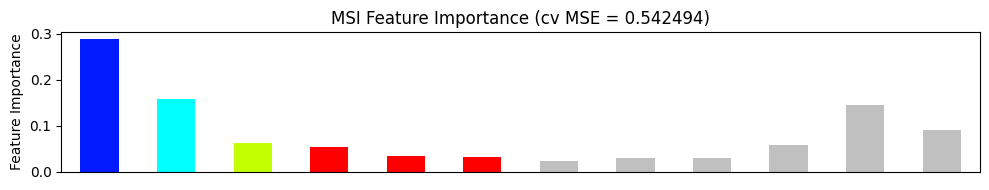

In [157]:
pipe_msi = exp_RFR_msi[2]
pd.Series(
    pipe_msi.regressor_.named_steps['regressor'].feature_importances_,
    index = wavelengths_msi).\
        plot(kind='bar',
             figsize=(10,2),
             color=[wavelength_to_rgb(w) for w in wavelengths_msi])
plt.xticks([])  # brak etykiet, bo mamy kolor
plt.ylabel("Feature Importance")
plt.title('MSI Feature Importance (cv MSE = %f)' % float(exp_mse_msi.loc['MEAN_MSE','MSE']))
plt.tight_layout()
plt.show()

In [ ]:
# SG deriv=1 usuwa importnace z wody
# SG deriv=2 znów o przywraca...



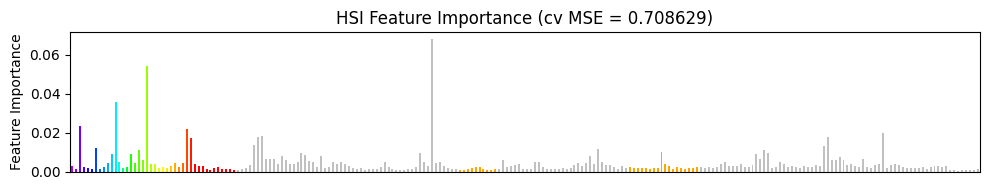

In [170]:
pipe_hsi = exp_RFR_hsi[2]

colors = []
water_color = 'orange'

klaster_1 = range(0, 98)
klaster_2 = range(108, 141)
klaster_3 = range(159, 230)
good_indices = list(klaster_1) + list(klaster_2) + list(klaster_3)

for i, w in enumerate(wavelengths_hsi):
    if i in good_indices:
        # Jeśli fala jest w klastrze, używamy Twojej funkcji koloru
        colors.append(wavelength_to_rgb(w))
    else:
        # Jeśli fala jest w "dziurze" między klastrami, kolorujemy na szarobłękitny
        colors.append(water_color)



pd.Series(
    pipe_hsi.regressor_.named_steps['regressor'].feature_importances_,
    index = wavelengths_hsi).\
        plot(kind='bar',
             figsize=(10,2),
             color=colors)
plt.xticks([])  # brak etykiet, bo mamy kolor
plt.ylabel("Feature Importance")
plt.title(f'HSI Feature Importance (cv MSE = %f)' % float(exp_mse_hsi.loc['MEAN_MSE','MSE']))
plt.tight_layout()
plt.show()

In [6]:
from pipeline_utils import (
    BandFilterSNR, SafeSNVTransformer, 
    spectral_binning, to_absorbance,
    PLSFeatureExtractor
)

rfParams = {'n_jobs': 4,
        'oob_score':True, 
        'max_depth': 10,
        'n_estimators': 500,
        'min_samples_leaf': 4}
gbParams = {
    'n_estimators':95, 'learning_rate':.04, 
}

rfr = RandomForestRegressor(**rfParams)
rpl = PLSRegression(n_components=12)
gbr = MultiOutputRegressor(GradientBoostingRegressor(**gbParams))

sg21 = FunctionTransformer(lambda x: savgol_filter(x, window_length=11, polyorder=2, deriv=1))
sg31 = FunctionTransformer(lambda x: savgol_filter(x, window_length=11, polyorder=3, deriv=1), )
sg20 = FunctionTransformer(lambda x: savgol_filter(x, window_length=11, polyorder=2, deriv=0))
sg30 = FunctionTransformer(lambda x: savgol_filter(x, window_length=11, polyorder=3, deriv=0))
snr = BandFilterSNR(threshold=1.3)
snv = SafeSNVTransformer()
binn = FunctionTransformer(spectral_binning, kw_args={'bin_size': 2})

abs = FunctionTransformer(to_absorbance)
extrPLS = PLSFeatureExtractor(n_components=12)

cubist = MultiOutputRegressor(Cubist(
    n_rules=15,
    n_committees=6,
    unbiased=True,
))

snr+abs+sg21+cubist15 _____ {'hsi'}
X_train shape: (1876, 230)
Y_train shape: (1876, 6)


/home/katarzyna/cv_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but Cubist was fitted with feature names
  warnings.warn(
/home/katarzyna/cv_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but Cubist was fitted with feature names
  warnings.warn(
/home/katarzyna/cv_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but Cubist was fitted with feature names
  warnings.warn(
/home/katarzyna/cv_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but Cubist was fitted with feature names
  warnings.warn(
/home/katarzyna/cv_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but Cubist was fitted with feature names
  warnings.warn(
/home/katarzyna/cv_env/lib/pyt

snr+pca+rf _____ {'msi'}
X_train shape: (1876, 12)
Y_train shape: (1876, 6)
snv+snr+pca+rf _____ {'msi'}
X_train shape: (1876, 12)
Y_train shape: (1876, 6)
sg20+snr+pls _____ {'hsi'}
X_train shape: (1876, 230)
Y_train shape: (1876, 6)
abs+sg21+snr+pls _____ {'hsi'}
X_train shape: (1876, 230)
Y_train shape: (1876, 6)
abs+sg21+snr+rf _____ {'msi', 'hsi'}
X_train shape: (1876, 12)
Y_train shape: (1876, 6)
X_train shape: (1876, 230)
Y_train shape: (1876, 6)
abs+sg21+snr+pca+rf _____ {'msi', 'hsi'}
X_train shape: (1876, 12)
Y_train shape: (1876, 6)
X_train shape: (1876, 230)
Y_train shape: (1876, 6)
abs+sg21+snr+extrPLS+rf _____ {'hsi'}
X_train shape: (1876, 230)
Y_train shape: (1876, 6)
abs+sg31+snr+rf _____ {'msi', 'hsi'}
X_train shape: (1876, 12)
Y_train shape: (1876, 6)
X_train shape: (1876, 230)
Y_train shape: (1876, 6)
sg30+snr+pca+rf _____ {'msi', 'hsi'}
X_train shape: (1876, 12)
Y_train shape: (1876, 6)
X_train shape: (1876, 230)
Y_train shape: (1876, 6)
sg31+snr+pca+rf _____ {'msi'

/tmp/ipykernel_216769/3357883707.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20c', 10)


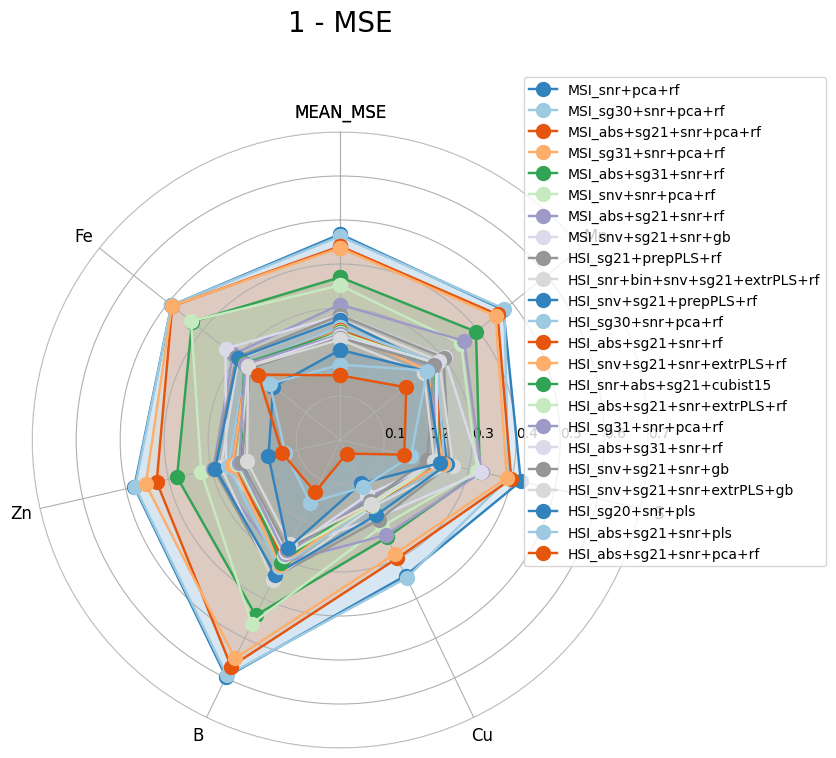

In [8]:
pipeline_0 = Pipeline([
     ('snr', snr), ('pca', PCA()), ("rf", rfr),
]), {'msi'}
pipeline_1b = Pipeline([
     ('snv', snv), ('snr', snr), ('pca', PCA()), ("rf", rfr),
]), {'msi'}
pipeline_cubist_0 = Pipeline([
    ('snr', snr),
    ('abs', abs),
    ('sg21', sg21),
    ('cubist15', cubist),
]), {'hsi'}
pipeline_1 = Pipeline([
    ('sg20', sg20), ('snr', snr), ("pls", rpl),
]), {'hsi'}
pipeline_2 = Pipeline([
    ('abs', abs), ('sg21', sg21), ('snr', snr), ("pls", rpl),
]), {'hsi'}
pipeline_3 = Pipeline([
    ('abs', abs), ('sg21', sg21), ('snr', snr), ("rf", rfr),
]), {'hsi', 'msi'}
pipeline_4 = Pipeline([
    ('abs', abs), ('sg21', sg20), ('snr', snr), ('pca', PCA()), ("rf", rfr),
]), {'hsi', 'msi'}
pipeline_5 = Pipeline([
    ('abs', abs), ('sg21', sg21),('snr', snr),  ('pca', PCA()), ("rf", rfr),
]), {'hsi', 'msi'}
pipeline_6 = Pipeline([
    ('abs', abs), ('sg21', sg21), ('snr', snr), ('extrPLS', extrPLS), ("rf", rfr),
]), {'hsi'}
pipeline_7 = Pipeline([
    ('abs', abs), ('sg31', sg31),('snr', snr), ("rf", rfr),
]), {'hsi', 'msi'}
pipeline_8 = Pipeline([
    ('sg30', sg30), ('snr', snr), ('pca', PCA()), ("rf", rfr),
]), {'hsi', 'msi'}
pipeline_9 = Pipeline([
    ('sg31', sg31),('snr', snr), ('pca', PCA()), ("rf", rfr),
]), {'hsi', 'msi'}
pipeline_10 = Pipeline([
    ("snv", snv), ('sg21', sg21),('snr', snr), ("gb", gbr),
]), {'hsi', 'msi'}
pipeline_11 = Pipeline([
    ("snv", snv), ('sg21', sg21),('snr', snr), ('extrPLS', extrPLS), ("gb", gbr),
]), {'hsi'}
pipeline_12 = Pipeline([
    ("snv", snv), ('sg21', sg21),('snr', snr), ('extrPLS', extrPLS), ("rf", rfr),
]), {'hsi'}
pipeline_13 = Pipeline([
    ('abs', abs), ('sg21', sg21),('snr', snr), ('extrPLS', extrPLS), ("rf", rfr),
]), {'hsi'}
pipeline_14 = Pipeline([
    ('snr', snr), ("bin", binn), ("snv", snv), ('sg21', sg21), ('extrPLS', extrPLS), ("rf", rfr),
]), {'hsi'}

total_bands = 230
klaster_1 = list(range(7, 98))    # VNIR
klaster_2 = list(range(108, 141))  # SWIR-1
klaster_3 = list(range(159, 223))  # SWIR-2
preprocessor_pls = ColumnTransformer([
    ('vnir_pls', PLSFeatureExtractor(n_components=8), klaster_1),
    ('swir1_pls', PLSFeatureExtractor(n_components=3), klaster_2),
    ('swir2_pls', PLSFeatureExtractor(n_components=5), klaster_3)
], remainder='drop')
pipeline_15 = Pipeline([
    # ('binning', binn), 
    ('sg21', sg21), ('prepPLS', preprocessor_pls), ('rf', rfr),
]), {'hsi'}
pipeline_15b = Pipeline([
    # ('binning', binn), 
    ('snv', snv), ('sg21', sg21), ('prepPLS', preprocessor_pls), ('rf', rfr),
]), {'hsi'}

EXPERIMENT_RESULTS = {}
for pip, dataset_names in [
    pipeline_cubist_0,
    pipeline_0,pipeline_1b,
    pipeline_1, pipeline_2,  # wywalić wszystkie pipeliny zawierające PLSRegressor na końcu.
      pipeline_3,pipeline_4, pipeline_5,
    pipeline_6, pipeline_7, pipeline_8, pipeline_9, pipeline_10,
    pipeline_11, pipeline_12, pipeline_13, pipeline_14, pipeline_15,    
    pipeline_15b,
]:
    name = '+'.join([ k for k,_ in pip.named_steps.items() ])
    if name in EXPERIMENT_RESULTS:
        continue
    if len({'hsi', 'msi'}.intersection(dataset_names))<1:
        pass
    print(name, '_____', dataset_names)
    temp_res = {}
    pipeline = TransformedTargetRegressor(regressor=pip, transformer=StandardScaler())
    if 'msi' in dataset_names:
        X_train_all, y_train_all, wavelengths_msi, y_names = load_data('msi')
        msi_res = run_experiment(
            pipeline,
            X_train_all, y_train_all,
            n_splits=3)
        temp_res['MSI'] = msi_res[0].rename(index=dict(zip(range(len(y_names)), y_names)))
        
    if 'hsi' in dataset_names:
        X_train_all, y_train_all, wavelengths_hsi, y_names = load_data('hsi')
        hsi_res = run_experiment(
            pipeline, X_train_all, y_train_all, n_splits=3)
        temp_res['HSI'] = hsi_res[0].rename(index=dict(zip(range(len(y_names)), y_names)))

    EXPERIMENT_RESULTS[name]=pd.concat(temp_res.values(), axis=0, keys=temp_res.keys())
res = plot_experiment_results(EXPERIMENT_RESULTS)

/tmp/ipykernel_216769/3357883707.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20c', 10)


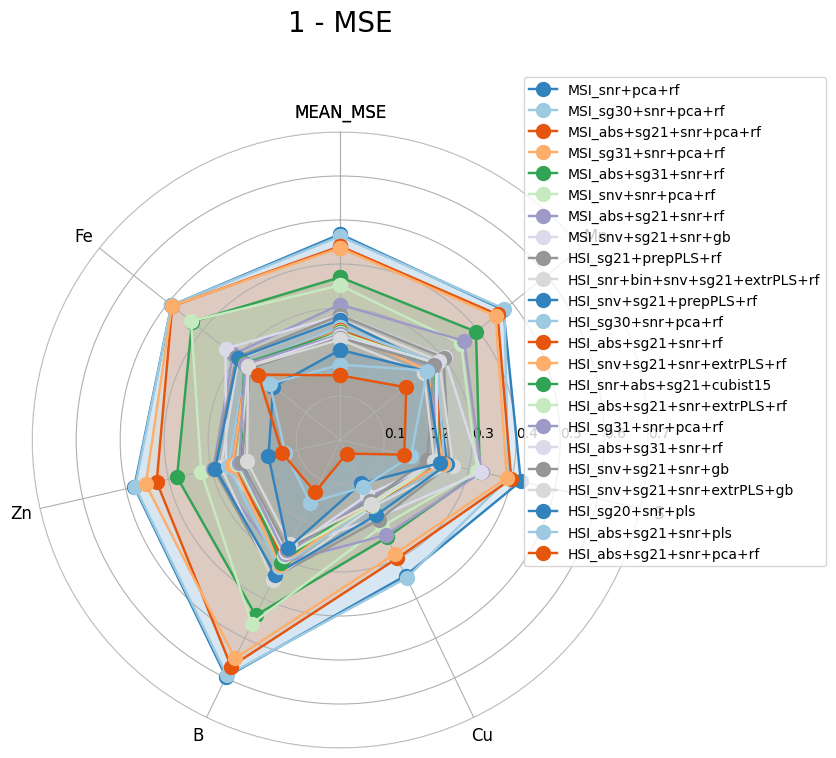

In [9]:
res = plot_experiment_results(EXPERIMENT_RESULTS)

/tmp/ipykernel_216769/3357883707.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20c', 10)


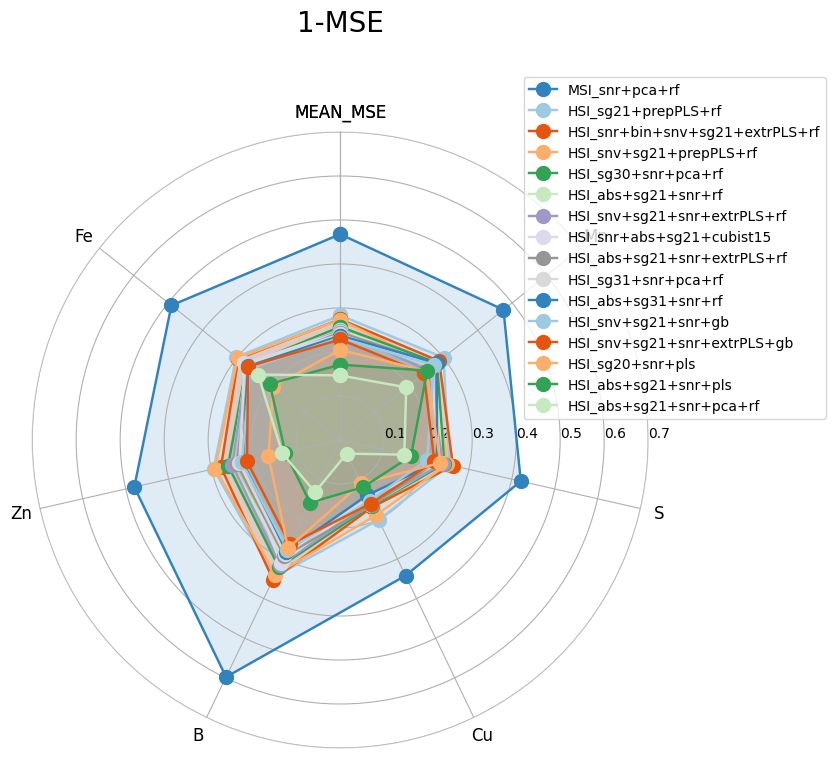

In [10]:
plot_radar_chart(res[res.index.str.contains('HSI|MSI_snr\+pca', regex=True)], '1-MSE')

/tmp/ipykernel_216769/3357883707.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20c', 10)


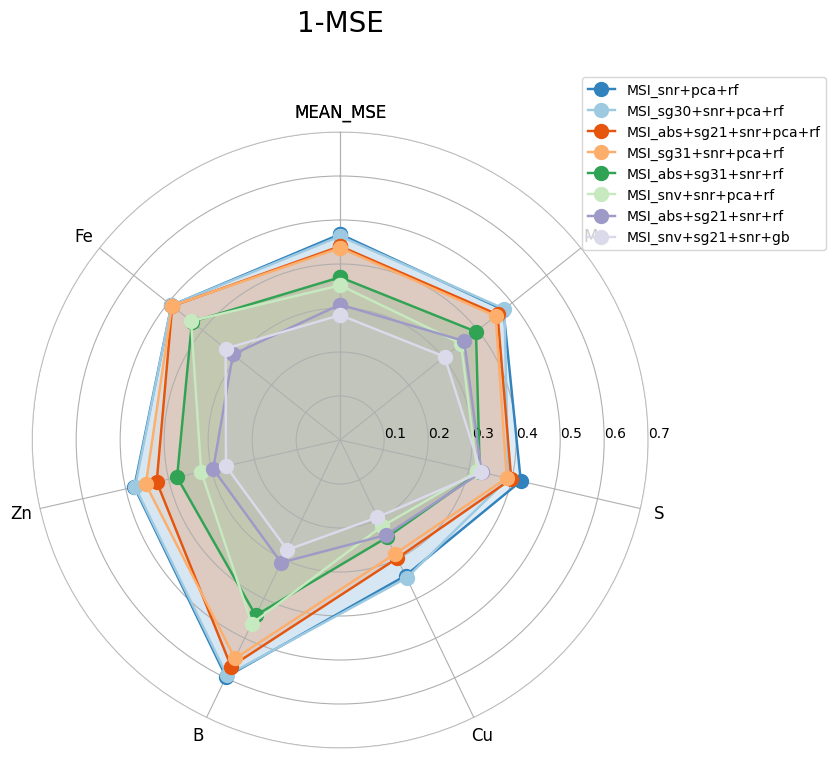

In [11]:
plot_radar_chart(res[res.index.str.contains('MSI')], '1-MSE')

In [12]:
print(res.sort_values('MEAN_MSE').to_markdown())

|                                 |       Fe |       Zn |        B |       Cu |        S |       Mn |   MEAN_MSE |
|:--------------------------------|---------:|---------:|---------:|---------:|---------:|---------:|-----------:|
| MSI_snr+pca+rf                  | 0.509402 | 0.520057 | 0.402159 | 0.657752 | 0.578939 | 0.525307 |   0.532269 |
| MSI_sg30+snr+pca+rf             | 0.509198 | 0.52196  | 0.406244 | 0.652157 | 0.608324 | 0.522356 |   0.536706 |
| MSI_abs+sg21+snr+pca+rf         | 0.511789 | 0.572254 | 0.428523 | 0.70148  | 0.601161 | 0.542443 |   0.559608 |
| MSI_sg31+snr+pca+rf             | 0.510976 | 0.546879 | 0.448967 | 0.712872 | 0.611608 | 0.548072 |   0.563229 |
| MSI_abs+sg31+snr+rf             | 0.569158 | 0.619765 | 0.55757  | 0.754407 | 0.674476 | 0.605178 |   0.630092 |
| MSI_snv+snr+pca+rf              | 0.56654  | 0.675979 | 0.536307 | 0.781913 | 0.680587 | 0.648773 |   0.64835  |
| MSI_abs+sg21+snr+rf             | 0.688093 | 0.703956 | 0.690672 | 0.760187 | 

In [13]:
pipeline_msi = TransformedTargetRegressor(
    regressor=pipeline_0[0], 
    transformer=StandardScaler())
pipeline_hsi = TransformedTargetRegressor(
    regressor=pipeline_cubist_0[0], 
    transformer=StandardScaler())

In [14]:
from sklearn.model_selection import train_test_split
Xtr, Xts, ytr, yts = train_test_split(X_train_all, y_train_all, test_size=.2, random_state=12)
Xtr.shape, Xts.shape, ytr.shape, yts.shape

((1500, 230), (376, 230), (1500, 6), (376, 6))

In [15]:
pipeline_msi.fit(Xtr, ytr)
pipeline_hsi.fit(Xtr, ytr)

baseline_reg = BaselineRegressor()
baseline_reg = baseline_reg.fit(None, ytr)

In [16]:
preds = pipeline_hsi.predict(Xts)
res = mse_metric(preds, yts, baseline_reg)
res.rename(index={i: y_names[i] for i in range(6)}).style.background_gradient()

/home/katarzyna/cv_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but Cubist was fitted with feature names
  warnings.warn(
/home/katarzyna/cv_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but Cubist was fitted with feature names
  warnings.warn(
/home/katarzyna/cv_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but Cubist was fitted with feature names
  warnings.warn(
/home/katarzyna/cv_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but Cubist was fitted with feature names
  warnings.warn(
/home/katarzyna/cv_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but Cubist was fitted with feature names
  warnings.warn(
/home/katarzyna/cv_env/lib/pyt

,MSE_EST,MSE,MSE_BL,MSE_%
Fe,2459.554063,0.641446,3834.391394,-35.855425
Zn,2.793469,0.688511,4.057263,-31.148939
B,0.040506,0.734067,0.055181,-26.593322
Cu,0.174291,0.807493,0.215842,-19.250722
S,133.283528,0.773679,172.272317,-22.632068
Mn,338.063581,0.752063,449.515158,-24.793730
MEAN_MSE,488.984906,0.732876,743.417859,-26.712368


In [17]:
preds = pipeline_msi.predict(Xts)
res = mse_metric(preds, yts, baseline_reg)
res.rename(index={i: y_names[i] for i in range(6)}).style.background_gradient()

,MSE_EST,MSE,MSE_BL,MSE_%
Fe,2488.945045,0.649111,3834.391394,-35.088915
Zn,2.907077,0.716512,4.057263,-28.348822
B,0.038424,0.696334,0.055181,-30.366645
Cu,0.177622,0.822926,0.215842,-17.707450
S,121.706739,0.706479,172.272317,-29.352121
Mn,341.946674,0.760701,449.515158,-23.929890
MEAN_MSE,492.620263,0.725344,743.417859,-27.465641


In [18]:
import re 
est = pipeline_hsi.regressor_.named_steps['cubist15']
i = 0 
fi = est.estimators_[i].feature_importances_
# fi['Variable'] = fi['Variable'].apply(lambda string_: ''.join([f"{int(s):03}" if s.isdigit() else s.lower() for s in re.split(r'(\d+)', string_)]))


<Axes: xlabel='Variable'>

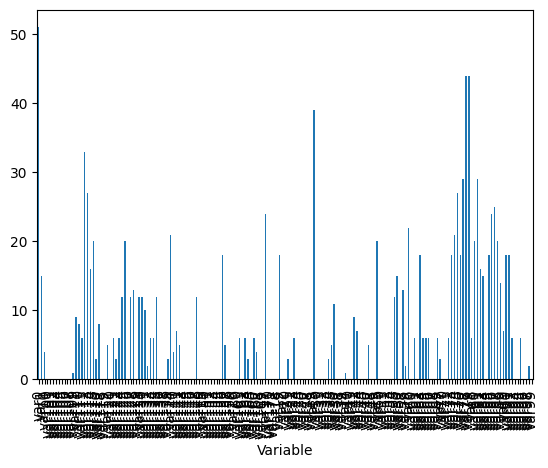

In [36]:
fi.set_index('Variable').sort_index()['Model'].plot(kind='bar')

In [20]:
preds = pipeline_hsi.predict(Xts)
mse_metric(preds, yts, baseline_reg)

/home/katarzyna/cv_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but Cubist was fitted with feature names
  warnings.warn(
/home/katarzyna/cv_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but Cubist was fitted with feature names
  warnings.warn(
/home/katarzyna/cv_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but Cubist was fitted with feature names
  warnings.warn(
/home/katarzyna/cv_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but Cubist was fitted with feature names
  warnings.warn(
/home/katarzyna/cv_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but Cubist was fitted with feature names
  warnings.warn(
/home/katarzyna/cv_env/lib/pyt

,MSE_EST,MSE,MSE_BL,MSE_%
0,2459.554063,0.641446,3834.391394,-35.855425
1,2.793469,0.688511,4.057263,-31.148939
2,0.040506,0.734067,0.055181,-26.593322
3,0.174291,0.807493,0.215842,-19.250722
4,133.283528,0.773679,172.272317,-22.632068
5,338.063581,0.752063,449.515158,-24.793730
MEAN_MSE,488.984906,0.732876,743.417859,-26.712368


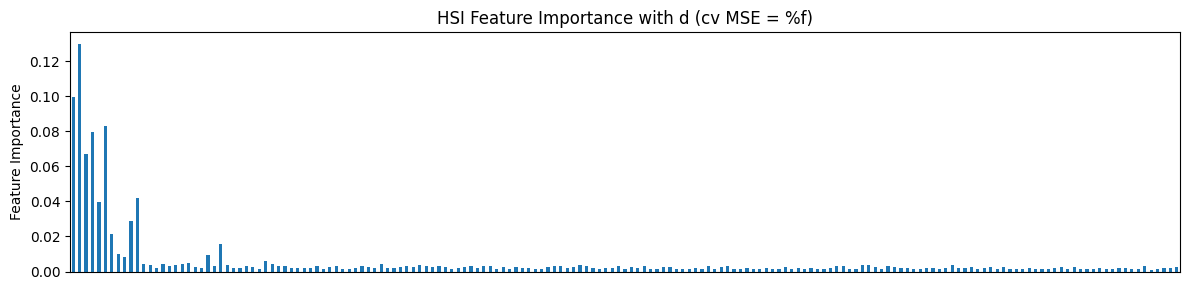

In [31]:
reg = pipeline_msi.regressor_.named_steps['rf']
pd.Series(
    reg.feature_importances_,
    # index = [f"SG_" for wl in wavelengths_hsi]
    ).\
        plot(kind='bar',
             figsize=(12,3),
            #  color=[wavelength_to_rgb(w) for w in wavelengths_hsi]
             )
plt.xticks([])  # brak etykiet, bo mamy kolor
plt.ylabel("Feature Importance")
plt.title(f'HSI Feature Importance with d (cv MSE = %f)')
plt.tight_layout()
plt.show()

In [35]:
reg = pipeline_hsi.regressor_.named_steps['regressor']
# deriv = pipe_hsi.regressor_.named_steps['derivative'].deriv
pd.Series(
    reg.feature_importances_,
    index = [f"SG_{wl}_deriv:{1}" for wl in wavelengths_hsi]).\
        plot(kind='bar',
             figsize=(12,3),
             color=[wavelength_to_rgb(w) for w in wavelengths_hsi]
             )
plt.xticks([])  # brak etykiet, bo mamy kolor
plt.ylabel("Feature Importance")
# plt.title(f'HSI Feature Importance with deriv={deriv} (cv MSE = %f)' % float(exp_mse_hsi.loc['MEAN_MSE','MSE']))
plt.tight_layout()
plt.show()

KeyError: 'regressor'